# Condiciones de la asignación principal

Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

Métrica principal: AUC-ROC.
Métrica adicional: exactitud.
Métrica ideal: AUC-ROC ≥ 0.88

In [1]:
#Carga de librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas.api.types import is_numeric_dtype

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.utils import shuffle

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from catboost import CatBoostClassifier, Pool

import sklearn.metrics as metrics


In [2]:
#Cargamos nuestros datos
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [3]:
#Visualizamos cada dataframe
display(contract.info())
print('---------------------------------------------------------------------')
contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

---------------------------------------------------------------------


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [4]:
#Visualizamos cada dataframe
display(personal.info())
print('-----------------------------------------------------')
personal.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

-----------------------------------------------------


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [5]:
#Visualizamos cada dataframe
display(internet.info())
print('-------------------------------------------')
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

-------------------------------------------


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [6]:
#Visualizamos cada dataframe
display(phone.info())
print('-------------------------------------------')
phone.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

-------------------------------------------


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [7]:
#Con la finalidad de un mejor analisis unificamos todos los dataframe en uno principal
data = contract.merge(internet, how='left', on='customerID')
data = data.merge(personal, how='left', on='customerID')
data = data.merge(phone, how='left', on='customerID')

data.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


In [8]:
# Revisamos sus datos
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   InternetService   5517 non-null   object 
 9   OnlineSecurity    5517 non-null   object 
 10  OnlineBackup      5517 non-null   object 
 11  DeviceProtection  5517 non-null   object 
 12  TechSupport       5517 non-null   object 
 13  StreamingTV       5517 non-null   object 
 14  StreamingMovies   5517 non-null   object 
 15  gender            7043 non-null   object 
 16  SeniorCitizen     7043 non-null   int64  


In [9]:
#Estandarizamos las columnas
data.columns = data.columns.str.lower()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   begindate         7043 non-null   object 
 2   enddate           7043 non-null   object 
 3   type              7043 non-null   object 
 4   paperlessbilling  7043 non-null   object 
 5   paymentmethod     7043 non-null   object 
 6   monthlycharges    7043 non-null   float64
 7   totalcharges      7043 non-null   object 
 8   internetservice   5517 non-null   object 
 9   onlinesecurity    5517 non-null   object 
 10  onlinebackup      5517 non-null   object 
 11  deviceprotection  5517 non-null   object 
 12  techsupport       5517 non-null   object 
 13  streamingtv       5517 non-null   object 
 14  streamingmovies   5517 non-null   object 
 15  gender            7043 non-null   object 
 16  seniorcitizen     7043 non-null   int64  


In [10]:
#Cambiamos el formato a tipo fecha
data['begindate'] = pd.to_datetime(data['begindate'])
data['begindate'].head()

0   2020-01-01
1   2017-04-01
2   2019-10-01
3   2016-05-01
4   2019-09-01
Name: begindate, dtype: datetime64[ns]

In [11]:
data['totalcharges'].unique()

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

In [12]:
#Cambiamos al formato correcto y los campos con formato errorneo se rellenan con NAN
data['totalcharges'] = pd.to_numeric(data['totalcharges'], errors='coerce')
data['totalcharges'].head()

0      29.85
1    1889.50
2     108.15
3    1840.75
4     151.65
Name: totalcharges, dtype: float64

In [13]:
#Revisamos los valores asuentes.
data.isnull().sum()

customerid             0
begindate              0
enddate                0
type                   0
paperlessbilling       0
paymentmethod          0
monthlycharges         0
totalcharges          11
internetservice     1526
onlinesecurity      1526
onlinebackup        1526
deviceprotection    1526
techsupport         1526
streamingtv         1526
streamingmovies     1526
gender                 0
seniorcitizen          0
partner                0
dependents             0
multiplelines        682
dtype: int64

In [14]:
#Fueron 11 los valores erroneos que se rellenaron con valores ausentes.
data[data['totalcharges'].isnull()]

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,gender,seniorcitizen,partner,dependents,multiplelines
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,DSL,Yes,No,Yes,Yes,Yes,No,Female,0,Yes,Yes,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,No,Yes,No
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN,DSL,Yes,Yes,Yes,No,Yes,Yes,Female,0,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN,DSL,Yes,Yes,Yes,Yes,Yes,No,Female,0,Yes,Yes,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,No
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,Yes
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,0,Yes,Yes,No
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,No
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN,DSL,No,Yes,Yes,Yes,Yes,No,Female,0,Yes,Yes,Yes


In [15]:
#Al ser una cantidad minoritaria los eleimando d la muestra y validamos nuevamente.
data = data.dropna(subset=['totalcharges'])
data['totalcharges'].isnull().sum()

0

In [16]:
#Vamos a procede a rellenar los valores ausentes de los servicios faltantes con 0 que nos indica que no cuenta con el servicio.
columns = ['paperlessbilling','partner','dependents','onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies','multiplelines']

#Para el analisis vamos a cambiar a tipo númerico 1 todo lo que sea "Yes" y 0 todos lo direferentes  "No".
for col in columns: 
  data.loc[data[col] == 'Yes', col] = 1
  data.loc[data[col] != 1, col] = 0

  data[col] = data[col].astype('int')


In [17]:
#Validamos nuevamente los valores asuentes.
data.isnull().sum()

customerid             0
begindate              0
enddate                0
type                   0
paperlessbilling       0
paymentmethod          0
monthlycharges         0
totalcharges           0
internetservice     1520
onlinesecurity         0
onlinebackup           0
deviceprotection       0
techsupport            0
streamingtv            0
streamingmovies        0
gender                 0
seniorcitizen          0
partner                0
dependents             0
multiplelines          0
dtype: int64

In [18]:
#Revisamos el valor faltantes y que datos tenemos.
data['internetservice'].unique()

array(['DSL', 'Fiber optic', nan], dtype=object)

In [19]:
#Lo rellenamos con un valor de referencia como None
data['internetservice'] = data['internetservice'].fillna('None')

In [20]:
#Revisamos nuevamente que ya no tengamos valores asuentes.
data.isnull().sum()

customerid          0
begindate           0
enddate             0
type                0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
gender              0
seniorcitizen       0
partner             0
dependents          0
multiplelines       0
dtype: int64

In [21]:
#Nuestro dataframe ya lo tenemos trabajdo
data .info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7032 non-null   object        
 1   begindate         7032 non-null   datetime64[ns]
 2   enddate           7032 non-null   object        
 3   type              7032 non-null   object        
 4   paperlessbilling  7032 non-null   int64         
 5   paymentmethod     7032 non-null   object        
 6   monthlycharges    7032 non-null   float64       
 7   totalcharges      7032 non-null   float64       
 8   internetservice   7032 non-null   object        
 9   onlinesecurity    7032 non-null   int64         
 10  onlinebackup      7032 non-null   int64         
 11  deviceprotection  7032 non-null   int64         
 12  techsupport       7032 non-null   int64         
 13  streamingtv       7032 non-null   int64         
 14  streamingmovies   7032 n

In [22]:
#Revisamos que no existan valores totalmente duplicados.
print(f'Existen {data.duplicated().sum()} valores totalmente duplicados')

Existen 0 valores totalmente duplicados


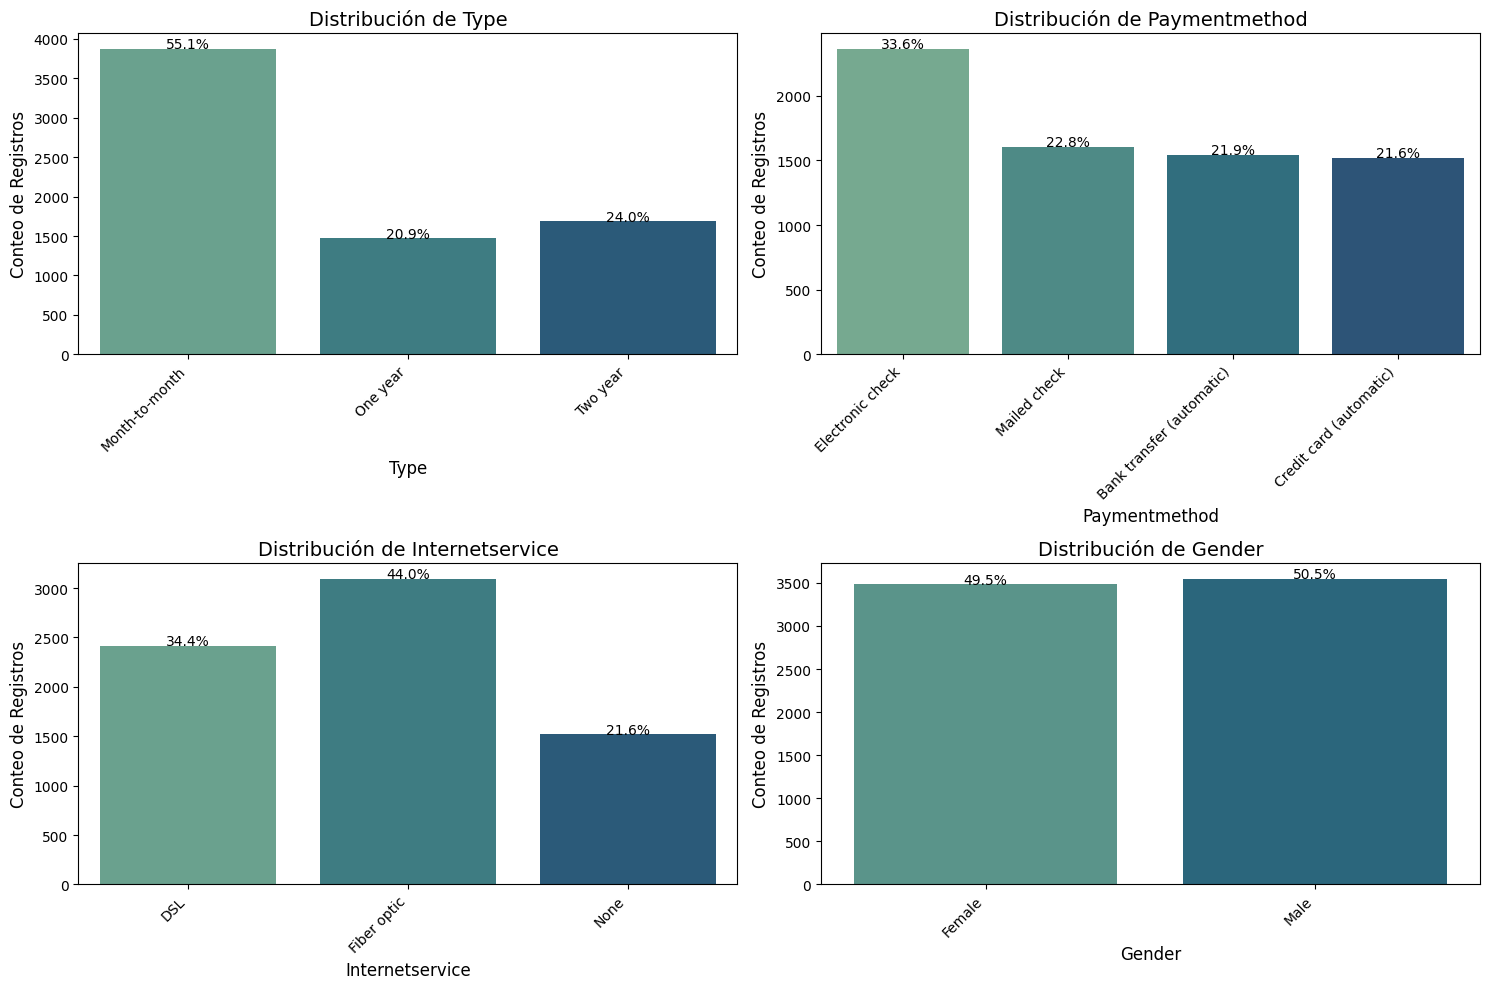

In [23]:
#Ahora graficaremos nuestras columnas categóricas para visualizarlas.
cols_to_plot = ['type', 'paymentmethod', 'internetservice', 'gender']

plt.figure(figsize=(15, 10))
total = len(data) 

for i, col in enumerate(cols_to_plot):
    plt.subplot(2, 2, i + 1)
    
    ax = sns.countplot(x=col, data=data, palette='crest')
    
    for p in ax.patches:
        height = p.get_height()
        
        if height > 0:
            percentage = '{:.1f}%'.format(100 * height / total)
            
            ax.text(
                p.get_x() + p.get_width() / 2., 
                height + 5, 
                percentage,
                ha="center", 
                fontsize=10
            )

    plt.title(f'Distribución de {col.capitalize()}', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel(col.capitalize(), fontsize=12)
    plt.ylabel('Conteo de Registros', fontsize=12)
    
plt.tight_layout()
plt.show()

La primera vista de nuestras columnas categóricas nos permite visualizar los valores y su proporción. Donde pudimos encontrar que la mayoría de nuestros clientes cuentan con un contrato de mes con mes tiene pago con cheque electrónico con servicio de fibra óptica y que no hay diferencia ya que las proporciones de genero son muy similares.

In [24]:
#Revisamos nuestros valores númericos
data[['monthlycharges', 'totalcharges']].describe()

,monthlycharges,totalcharges
count,7032.000000,7032.000000
mean,64.798208,2283.300441
std,30.085974,2266.771362
min,18.250000,18.800000
25%,35.587500,401.450000
50%,70.350000,1397.475000
75%,89.862500,3794.737500
max,118.750000,8684.800000


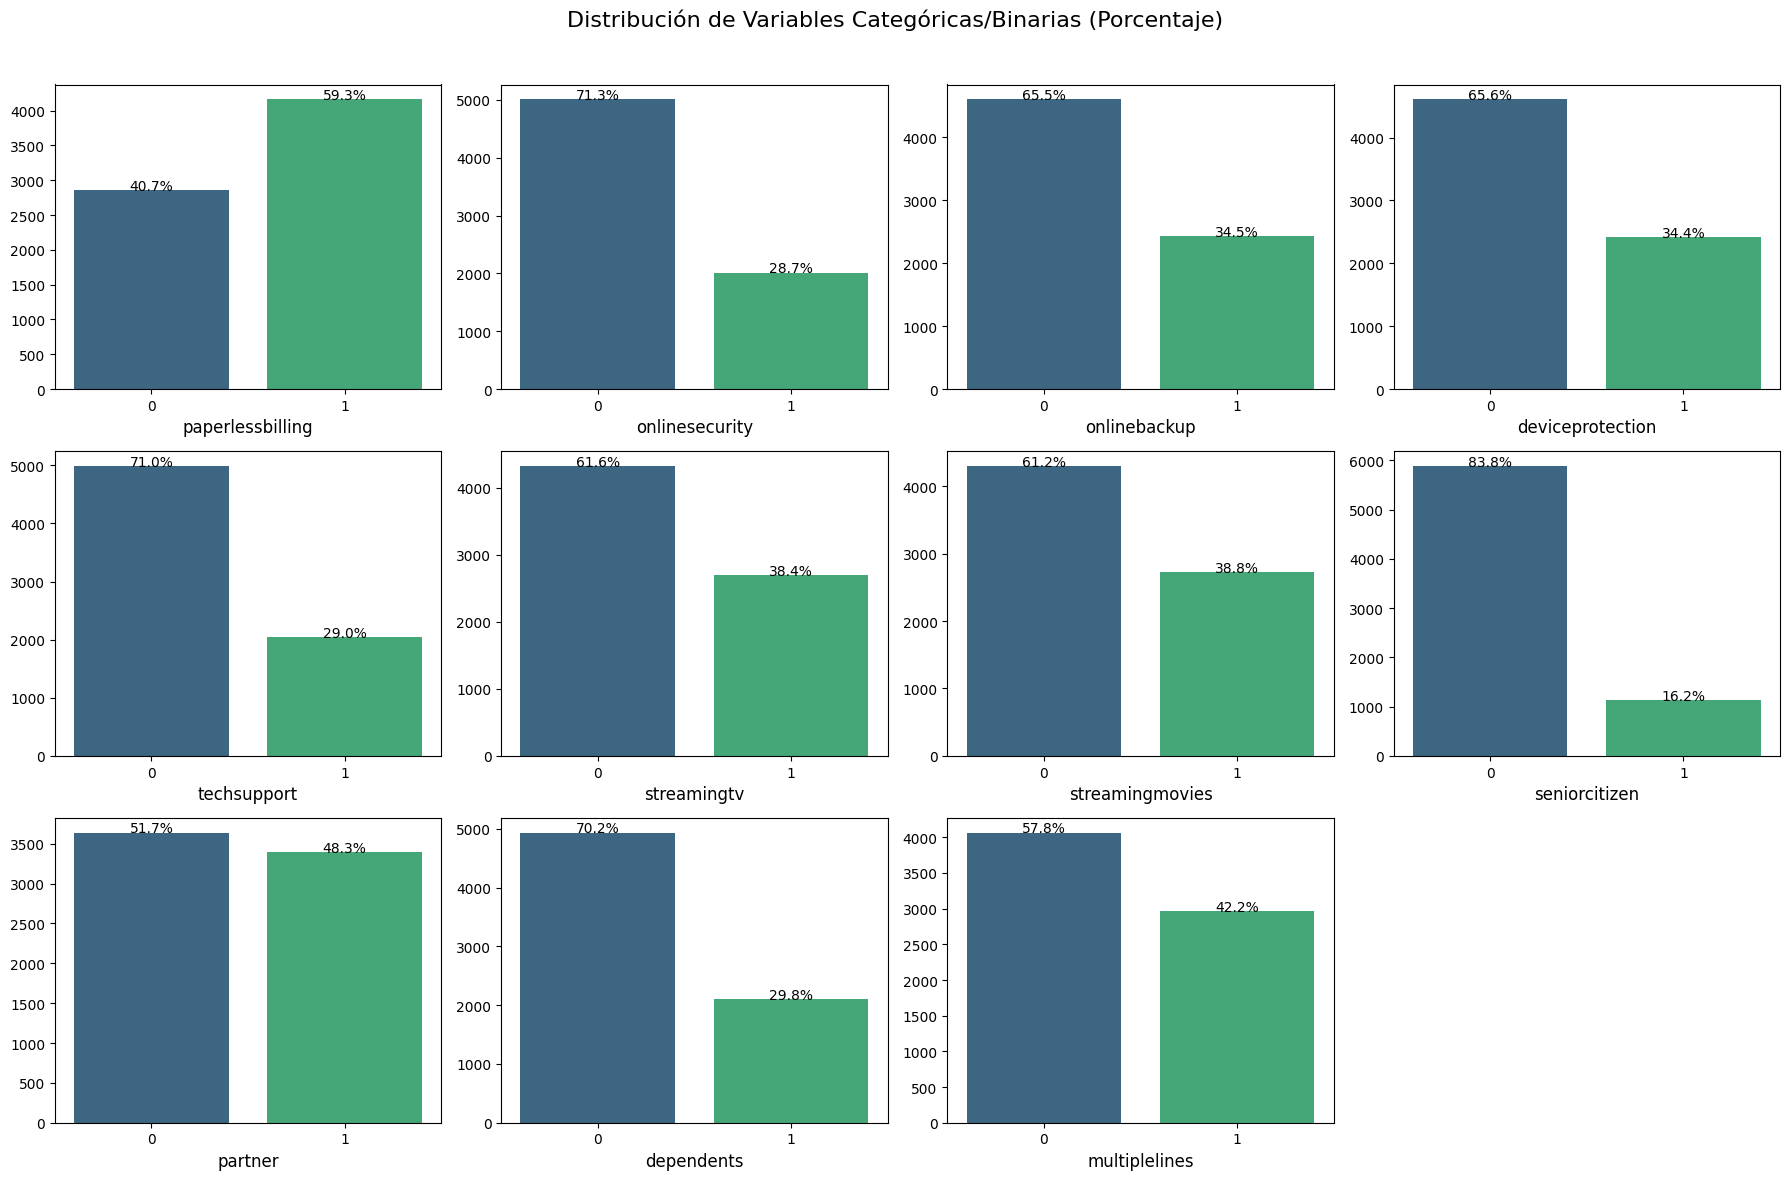

In [25]:
# Y graficamos las columnas booleanas.
bool_col = ['paperlessbilling', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'seniorcitizen', 'partner', 'dependents', 'multiplelines']

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 12))
axes = axes.flatten()

fig.suptitle('Distribución de Variables Categóricas/Binarias (Porcentaje)', fontsize=16)

for i, col in enumerate(bool_col):
    ax = sns.countplot(x=col, data=data, ax=axes[i], palette='viridis')
    
    total = len(data)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2.,
                height + 3, 
                '{:1.1f}%'.format(100 * height/total),
                ha="center", fontsize=10)
        ax.set_ylabel("")
    ax.set_xlabel(col, fontsize=12)

for j in range(len(bool_col), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

Mientras que para nuestros datos booleanos pudimos observar que hay más clientes que han optado por la facturación sin papel, la gran mayoría de los clientes en el conjunto de datos no son personas mayores, tenemos más clientes que tiene una dependencia por su parte estamos más equilibrados con los clientes que son partner, también tenemos más con clientes líneas múltiples y por último la mayoría de los clientes no contrata los servicios adicionales. 
Estos datos los camparemos con nuestra variable objetivo para encontrar más detalle en cada uno más adelantes. 

In [26]:

data['aim'] = (data['enddate'] != "No").astype("int")
data.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,gender,seniorcitizen,partner,dependents,multiplelines,aim
0,7590-VHVEG,2020-01-01,No,Month-to-month,1,Electronic check,29.85,29.85,DSL,0,...,0,0,0,0,Female,0,1,0,0,0
1,5575-GNVDE,2017-04-01,No,One year,0,Mailed check,56.95,1889.50,DSL,1,...,1,0,0,0,Male,0,0,0,0,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,1,Mailed check,53.85,108.15,DSL,1,...,0,0,0,0,Male,0,0,0,0,1
3,7795-CFOCW,2016-05-01,No,One year,0,Bank transfer (automatic),42.30,1840.75,DSL,1,...,1,1,0,0,Male,0,0,0,0,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,1,Electronic check,70.70,151.65,Fiber optic,0,...,0,0,0,0,Female,0,0,0,0,1


In [27]:
# Revisamos nuestro valor objetivo.
data['aim'].value_counts(normalize=True)


0    0.734215
1    0.265785
Name: aim, dtype: float64

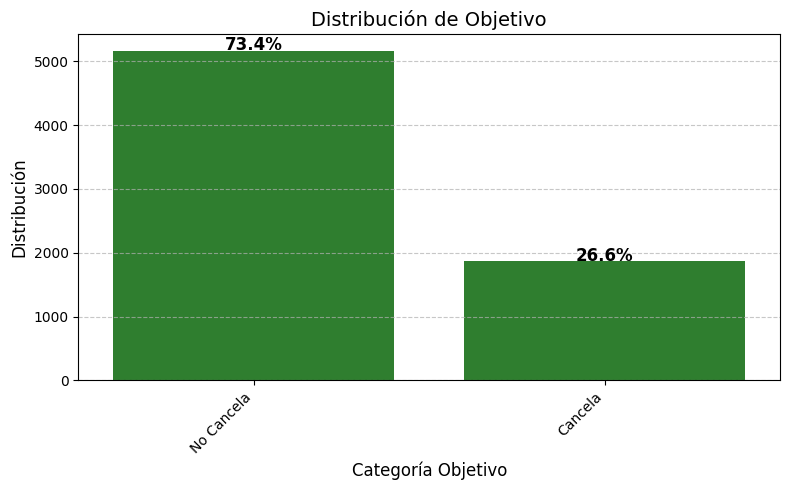

In [28]:
#Y graficamos su proporción para el analisis.
plt.figure(figsize=(8, 5))

data['aim_label'] = data['aim'].replace({
    1: 'Cancela', 
    0: 'No Cancela'
})

ax = sns.countplot(x='aim_label', data=data, color='forestgreen') 
total = len(data['aim'])

for p in ax.patches:
    height = p.get_height()
    percentage = '{:.1f}%'.format(100 * height / total)
    x = p.get_x() + p.get_width() / 2  
    y = height 
    
    ax.text(
        x, 
        y + 6,     
        percentage, 
        ha='center',
        size=12,     
        weight='bold' 
    )

plt.title('Distribución de Objetivo', fontsize=14)
plt.xlabel('Categoría Objetivo', fontsize=12)
plt.ylabel('Distribución', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Una vez analisizando los valores de nuestro objetivo podemos confirmar que la dstribucion muestra un claro desbalance de clases.
#### El 73.4% de los clientes pertenecen a la clase mayoritaria (No Cancela, 0), mientras que solo el 26.6% pertenece a la clase minoritaria (Cancela, 1).

#### Esto justifica completamente la decisión de utilizar métricas robustas como ROC AUC y APS en lugar de depender únicamente de la Accuracy, ya que la mayor parte del tiempo obtendría una Accuracy menores a las metricas solicitadas.

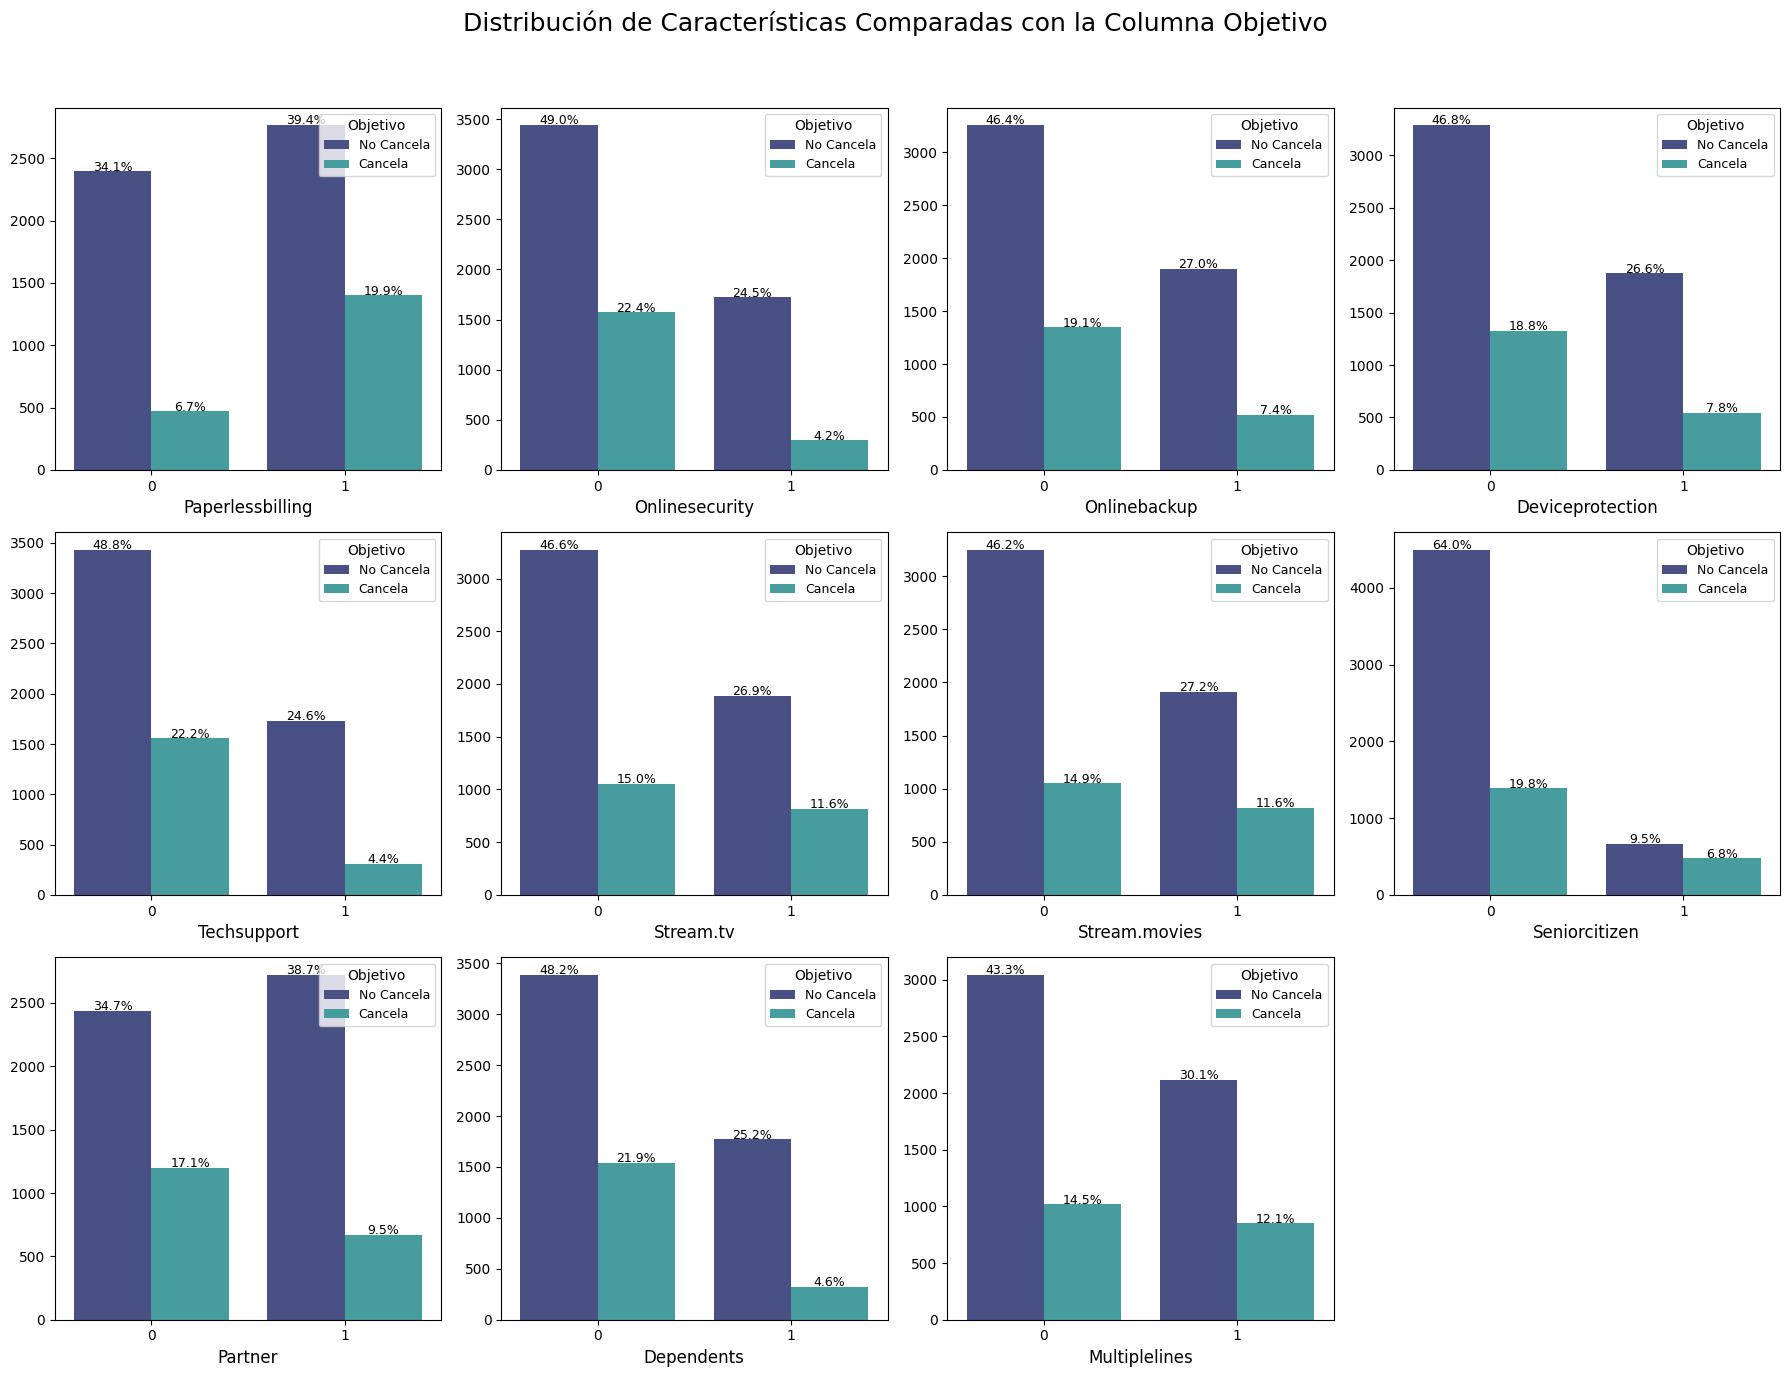

In [29]:
#Ahora graficaremos nuevamente nuestros valores booleanos pero con la relacion de nuestro valor objetivo.
bool_col = ['paperlessbilling', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 
            'techsupport', 'streamingtv', 'streamingmovies', 'seniorcitizen', 
            'partner', 'dependents', 'multiplelines']

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 14)) 
axes = axes.flatten()

fig.suptitle('Distribución de Características Comparadas con la Columna Objetivo', fontsize=18)

total = len(data)
data['aim_label'] = data['aim'].replace({
    1: 'Cancela', 
    0: 'No Cancela'
})

for i, col in enumerate(bool_col):
    ax = sns.countplot(x=col, data=data, hue='aim_label', ax=axes[i], palette='mako')
    
    for p in ax.patches:
        height = p.get_height()
        
        if height > 0:
            ax.text(
                p.get_x() + p.get_width() / 2.,
                height + 5, 
                '{:1.1f}%'.format(100 * height / total),
                ha="center", 
                fontsize=9,
                color='black'
            )
            
    ax.set_ylabel("")
    ax.set_xlabel(col.replace('streaming', 'stream.').capitalize(), fontsize=12)
    ax.legend(title='Objetivo', fontsize=9) 

for j in range(len(bool_col), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

Despues de visualizar las relaciones podemos concluir para cada valor que:

PaperlessBilling: Los clientes que reciben facturas sin papel tienen una tasa de cancelación notablemente más alta en comparación con aquellos que reciben facturas en papel.

SeniorCitizen: Los ciudadanos mayores tienen una tasa de cancelación más alta que los clientes más jóvenes.

Partner y Dependents: Los clientes que no son Partner e igual que no tiene Dependents son más propensos a cancelar que aquellos que tienen si son Partner o tiene Dependents.

MultipleLines: Los clientes con líneas múltiples tienen una tasa de cancelación ligeramente más alta que aquellos con una sola línea o sin servicio telefónico.

Y por ultimo para los servicios adicionales OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies: Los clientes que no tienen servicios adicionales como seguridad en línea, copia de seguridad en línea, protección de dispositivos, soporte técnico, transmisión de TV y transmisión de películas tienden a cancelar más que aquellos que sí los tienen. Esto sugiere que ofrecer y promover estos servicios podría ayudar a retener a los clientes.

##### Una vez analisando esto datos podemos concluir que nuestro cliente objetivo dene de estar principalmente en el segmento de los clientes moyores que no es partner, no tiene dependencia , no cuenta con servicio adicionales contratados y recibe sus facturas sin papel que son los clietes más propensos a cancelar.
##### Por lo que que se buscaria ofrecerles más promociones, beneficios o planes, priviligeando a este segmento para reducir la tasa de cancelación.



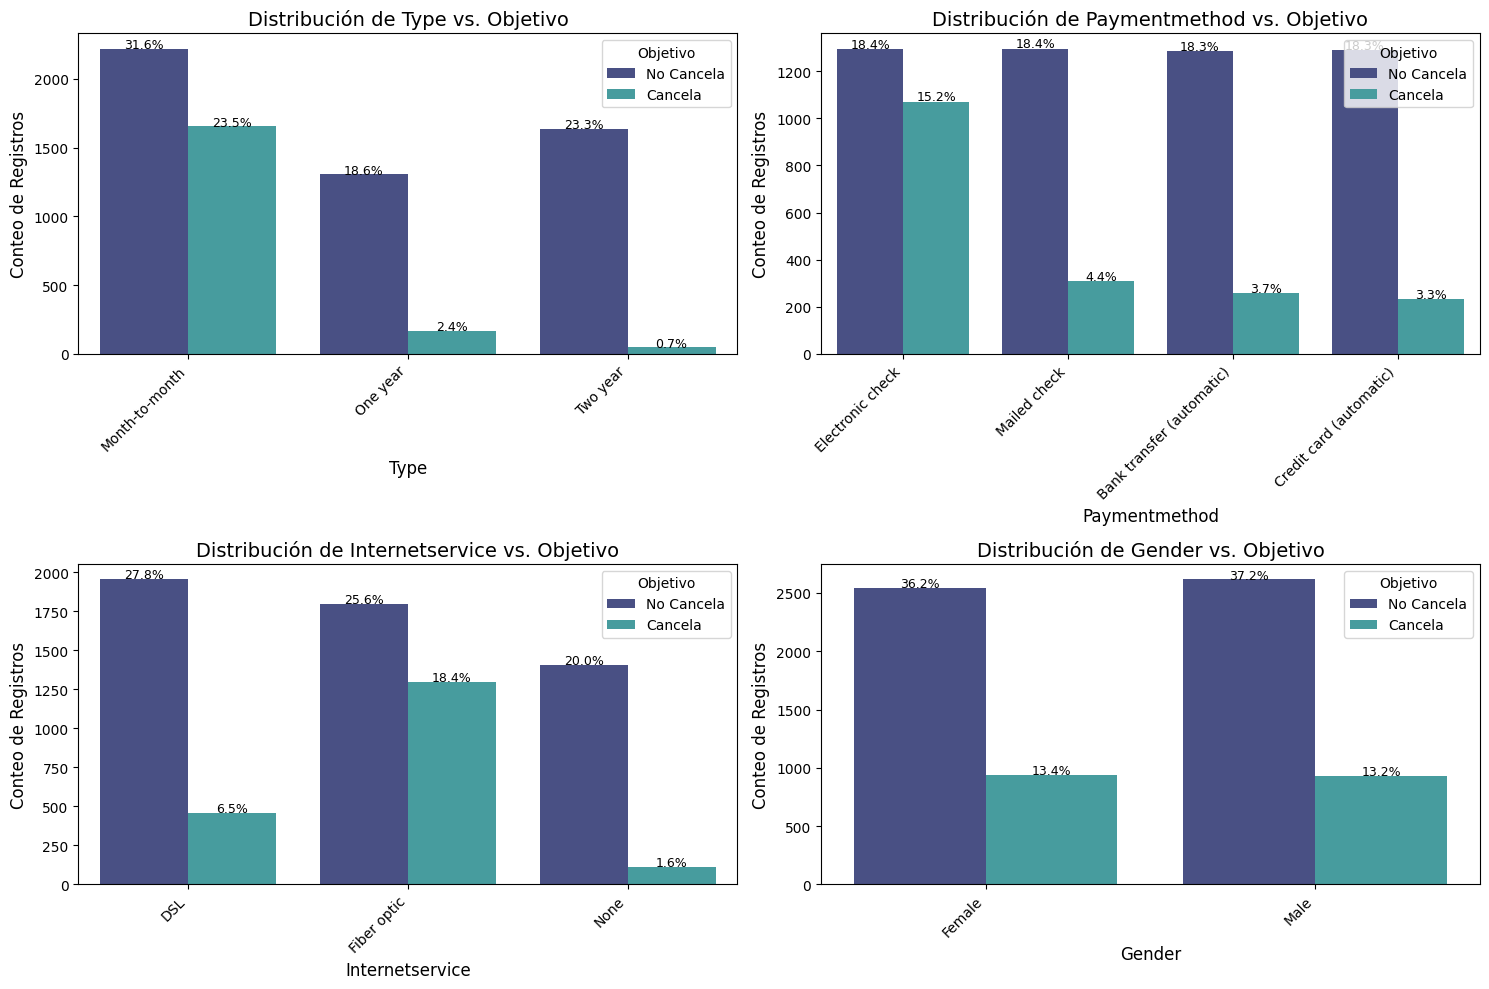

In [30]:
#Y de la misma manera pero con las columnas categóricas.
cols_to_plot = ['type', 'paymentmethod', 'internetservice', 'gender']

plt.figure(figsize=(15, 10))
total = len(data)

data['aim_label'] = data['aim'].replace({
    1: 'Cancela', 
    0: 'No Cancela'
})

for i, col in enumerate(cols_to_plot):
    plt.subplot(2, 2, i + 1)
    
    ax = sns.countplot(x=col, data=data, hue='aim_label', palette='mako')
    
    for p in ax.patches:
        height = p.get_height()
        
        if height > 0:
            percentage = '{:.1f}%'.format(100 * height / total)
            
            ax.text(
                p.get_x() + p.get_width() / 2., 
                height + 5,  
                percentage,
                ha="center", 
                fontsize=9
            )

    plt.title(f'Distribución de {col.capitalize()} vs. Objetivo', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel(col.capitalize(), fontsize=12)
    plt.ylabel('Conteo de Registros', fontsize=12)
    ax.legend(title='Objetivo', loc='upper right')
    
plt.tight_layout()
plt.show()


Aqui obtuvimos más algunos valores relevantes para el analisis ya que tenemos una mayoria de la cancelaciones en los tipo de contrato que son mes por mes y que tiene pago de cheque electronico.
    Esto puede ser al no tener un plan forsozo estos usuarios tiene mas libertad para cancelar el servicio sin ningun problema o penalización. 

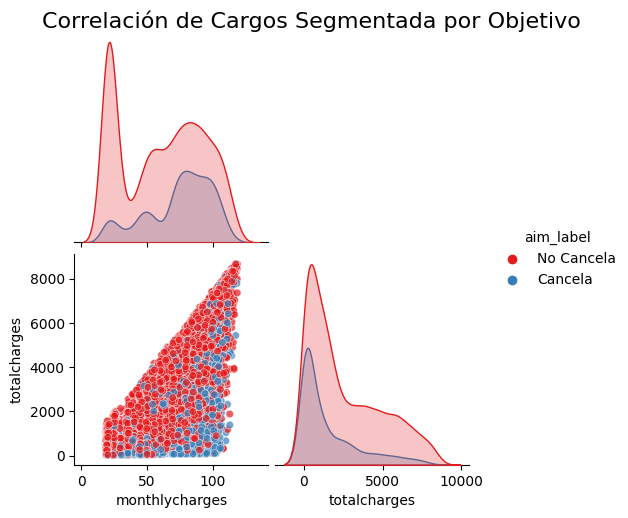

In [31]:
# Ahora revisamos la correlacion de nuestros valores numericos.
data['aim_label'] = data['aim'].replace({
    1: 'Cancela', 
    0: 'No Cancela'
})

sns.pairplot(
    data[['monthlycharges', 'totalcharges', 'aim_label']],
    hue='aim_label',                      
    corner=True,                    
    diag_kind='kde',                
    palette='Set1',                 
    plot_kws={'alpha': 0.7, 's': 30} 
)

plt.suptitle('Correlación de Cargos Segmentada por Objetivo', y=1.02, fontsize=16) 
plt.show()

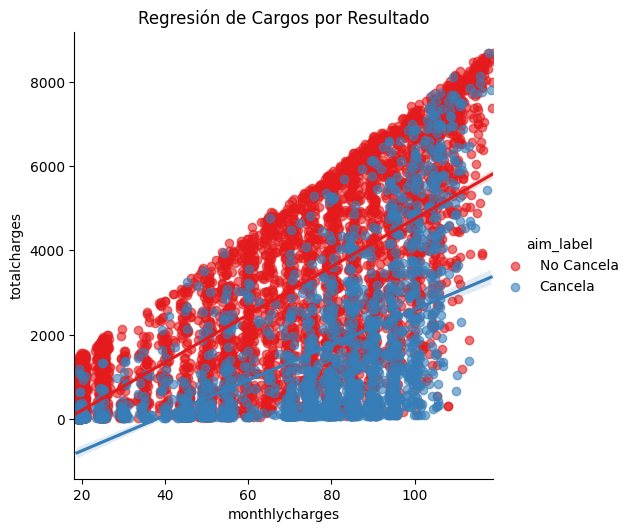

In [32]:
# Muestra la línea de tendencia de la correlación de Total vs. Mensual
data['aim_label'] = data['aim'].replace({
    1: 'Cancela', 
    0: 'No Cancela'
})
sns.lmplot(
    x='monthlycharges', 
    y='totalcharges', 
    hue='aim_label',          # Segmentado por el objetivo
    data=data, 
    palette='Set1',
    scatter_kws={'alpha': 0.6} # Transparencia para los puntos
)
plt.title('Regresión de Cargos por Resultado')
plt.show()

In [33]:
#Revisamos los valores númericos
data[['monthlycharges', 'totalcharges', 'aim']].corr()

,monthlycharges,totalcharges,aim
monthlycharges,1.000000,0.651065,0.192858
totalcharges,0.651065,1.000000,-0.199484
aim,0.192858,-0.199484,1.000000


Tenemos una pequeña relacion positiva entre la columna objetivo y la columna monthlycharges.
Y poe contrario de la isma forma pero negativa con la columna totalcharges.

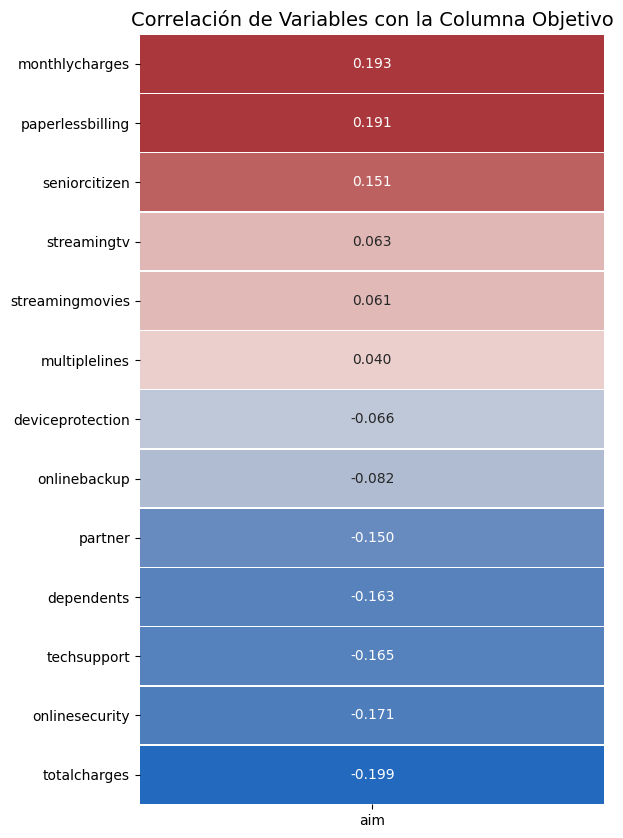

In [34]:
#Revisamos las correlacion del resto de las colaumnas
corr_with_aim = data.corr()['aim'].drop('aim').sort_values(ascending=False)

#Convertir la Serie de correlaciones a un DataFrame para el heatmap
corr_df = pd.DataFrame(corr_with_aim)

plt.figure(figsize=(6, 10)) 

sns.heatmap(
    corr_df,
    annot=True,              # Muestra el valor numérico (precisión)
    cmap='vlag',             # Paleta divergente (ideal para correlación positiva/negativa)
    fmt=".3f",               # Formato con dos decimales
    linewidths=.3,           # Añade líneas para separar celdas
    cbar=False               # Quita la barra lateral de color (ya que solo es una columna)
)

plt.title('Correlación de Variables con la Columna Objetivo', fontsize=14)
plt.show()

Con nuestro mapa de calor es mas visible observar que valores tiene una ralcion negaiva o positiva.

In [35]:
#Es hora de explorar las colmunas de fecha
data['begindate'].describe(datetime_is_numeric=True)

count                             7032
mean     2017-04-28 23:14:44.641638400
min                2013-10-01 00:00:00
25%                2015-06-01 00:00:00
50%                2017-09-01 00:00:00
75%                2019-04-01 00:00:00
max                2020-01-01 00:00:00
Name: begindate, dtype: object

Tenemos una fecha de inicio que data del 2013-10-01 y concluimos con el 2020-01-01

In [36]:
#Por lo que generamos una pequeña muestra con el fin de analisar la finalización de los contratos. 
contrato_finalizado = data[data['enddate'] != 'No'].copy()
contrato_finalizado['enddate'] = pd.to_datetime(contrato_finalizado['enddate'])

In [37]:
# Revisamos los valores de nuestra muestra
contrato_finalizado['enddate'].describe(datetime_is_numeric=True)


count                             1869
mean     2019-11-15 21:31:18.009630464
min                2019-10-01 00:00:00
25%                2019-11-01 00:00:00
50%                2019-11-01 00:00:00
75%                2019-12-01 00:00:00
max                2020-01-01 00:00:00
Name: enddate, dtype: object

Pudimos validar que las cancelaciones las tenemos en la ventana de tiempo del 2019-10-01 al 2020-01-01 que es el fin de nuestra muestra.

In [38]:
#Preparamos la muestra paea una analisis de lineas de tiempo
contrato_finalizado.set_index(keys='enddate', inplace=True)

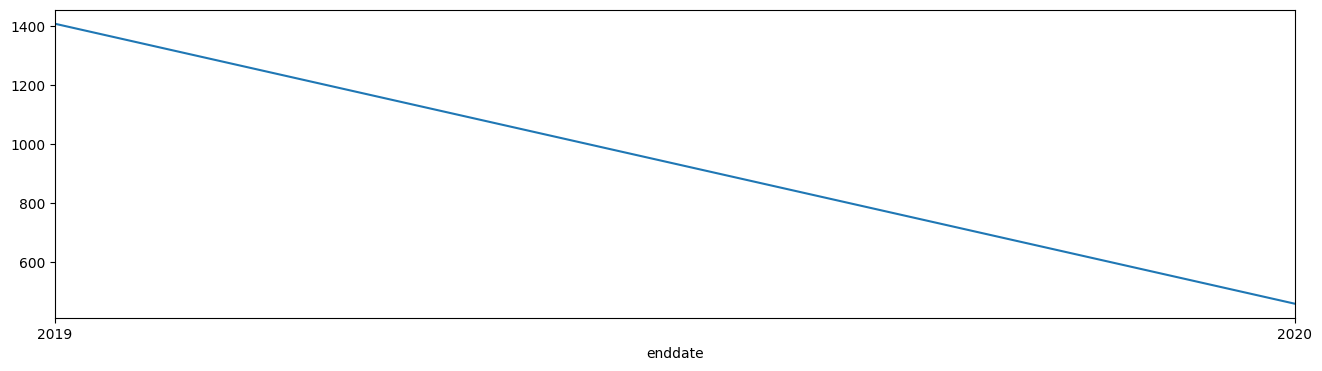

In [39]:
#Y revisamos la muestra en años
contrato_finalizado.resample('1Y')['aim'].sum().plot(figsize=(16,4))
plt.xlim()
plt.show()




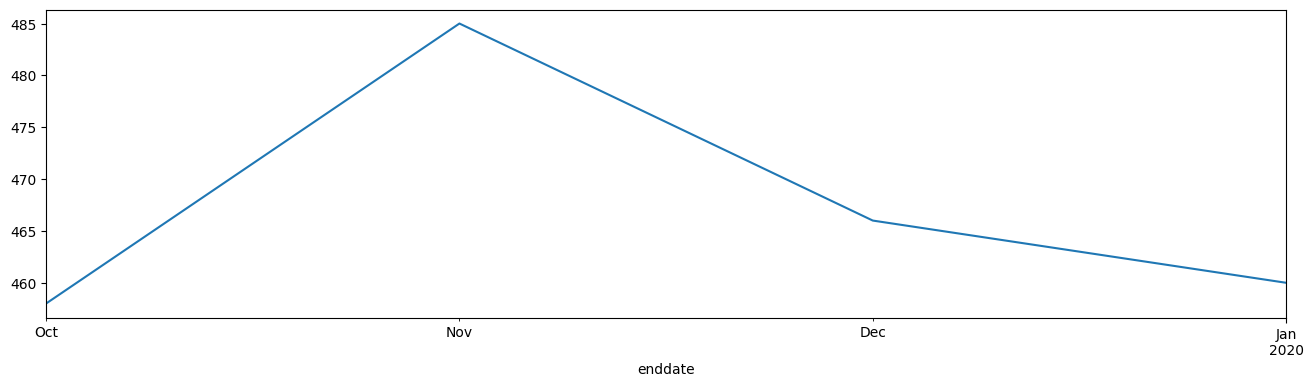

In [40]:
#En meses 
contrato_finalizado.resample('1M')['aim'].sum().plot(figsize=(16,4))
plt.xlim()
plt.show()


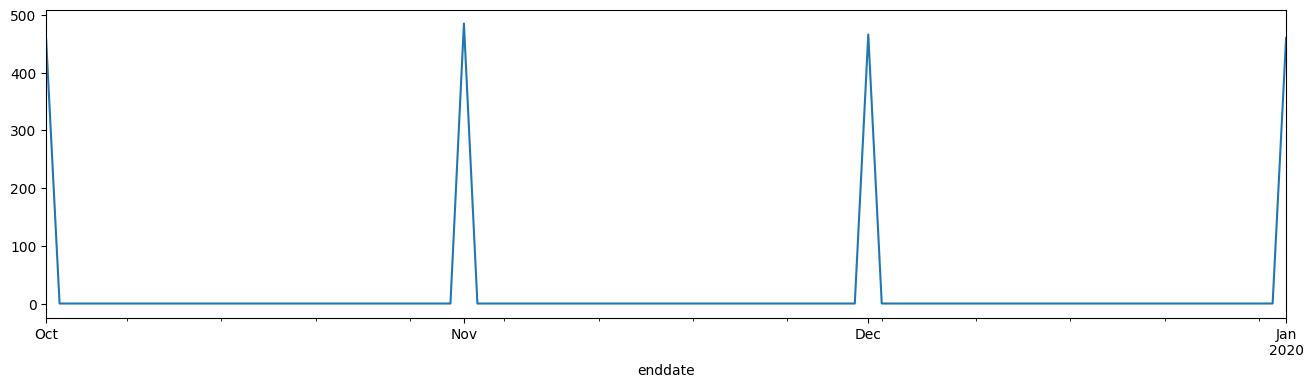

In [41]:
#Y por ultimo en días
contrato_finalizado.resample('1D')['aim'].sum().plot(figsize=(16,4))
plt.xlim()
plt.show()


Por lo que pudimos visualizar la temporalidad de las cancelaciones y su distribucion la cual nos arroga que es posible que los usuarios cancela con mas posibilidad entre finales y principios del mes ques cuando puedan tener su corte. 

In [42]:
data['begindate'].describe(datetime_is_numeric=True)

count                             7032
mean     2017-04-28 23:14:44.641638400
min                2013-10-01 00:00:00
25%                2015-06-01 00:00:00
50%                2017-09-01 00:00:00
75%                2019-04-01 00:00:00
max                2020-01-01 00:00:00
Name: begindate, dtype: object

In [43]:
#Vamos a rellenar los valores que no tiene fecha fin con el ultimo día de la muestra para evaluar los meses y días de las duraciones de los contratos que se cancelan
FECHA_DE_CORTE = pd.to_datetime('2020-01-01')

data['enddate'] = pd.to_datetime(data['enddate'], errors='coerce')

data['enddate'] = data['enddate'].fillna(FECHA_DE_CORTE)

data['begindate'] = pd.to_datetime(data['begindate'])

In [44]:
#Calculamos los valores para nuestras dos nuevas columnas. 
data['duration_days'] = (data['enddate'] - data['begindate']).dt.days

data['duration_months'] = round(data['duration_days'] / 30.4375).astype(int) 
data = data.drop(['begindate', 'enddate'], axis=1)

In [45]:
#Revisamos los datos por mes
data['duration_months'].describe()

count    7032.000000
mean       31.687571
std        24.392347
min         0.000000
25%         8.000000
50%        28.000000
75%        55.000000
max        72.000000
Name: duration_months, dtype: float64

In [46]:
#Revisamos los valores 
data['duration_months'].unique()

array([ 0, 33,  2, 44,  8, 21,  9, 28, 61, 12, 15, 57, 49, 24, 68, 51, 70,
       10, 20,  1, 11, 48, 29, 47, 71, 17, 26,  5, 45, 34, 69, 16, 62, 42,
       59, 18, 65, 46, 30, 63, 55,  7, 41, 64, 25, 37,  4, 31, 35, 40,  3,
        6, 32, 27, 66, 22, 56, 60, 14, 13, 52, 58, 53, 19, 39, 23, 43, 50,
       67, 38, 54, 36, 72])

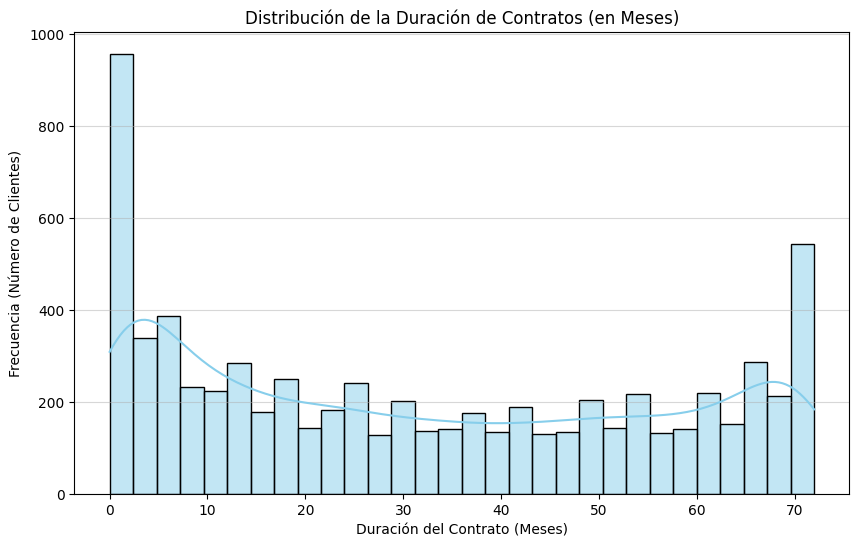

In [47]:
# Y graficamos recoradando que el valor atipico de 0 es donde no existe una cancelacón.
plt.figure(figsize=(10, 6))

sns.histplot(data=data, x='duration_months', kde=True, bins=30, color='skyblue')

plt.title('Distribución de la Duración de Contratos (en Meses)')
plt.xlabel('Duración del Contrato (Meses)')
plt.ylabel('Frecuencia (Número de Clientes)')
plt.grid(axis='y', alpha=0.5)

plt.show()

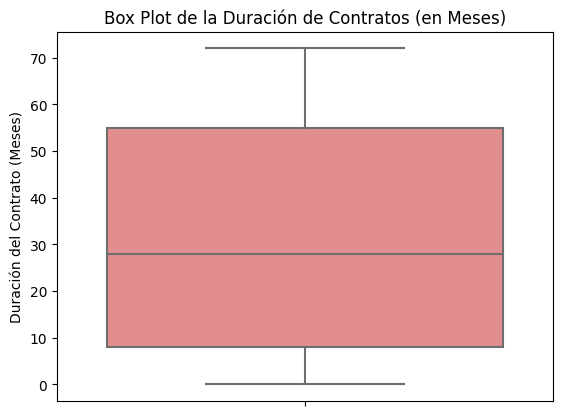

In [48]:
#Otra grafica de los datos.
sns.boxplot(y=data['duration_months'], color='lightcoral')

plt.title('Box Plot de la Duración de Contratos (en Meses)')
plt.ylabel('Duración del Contrato (Meses)')
plt.show()

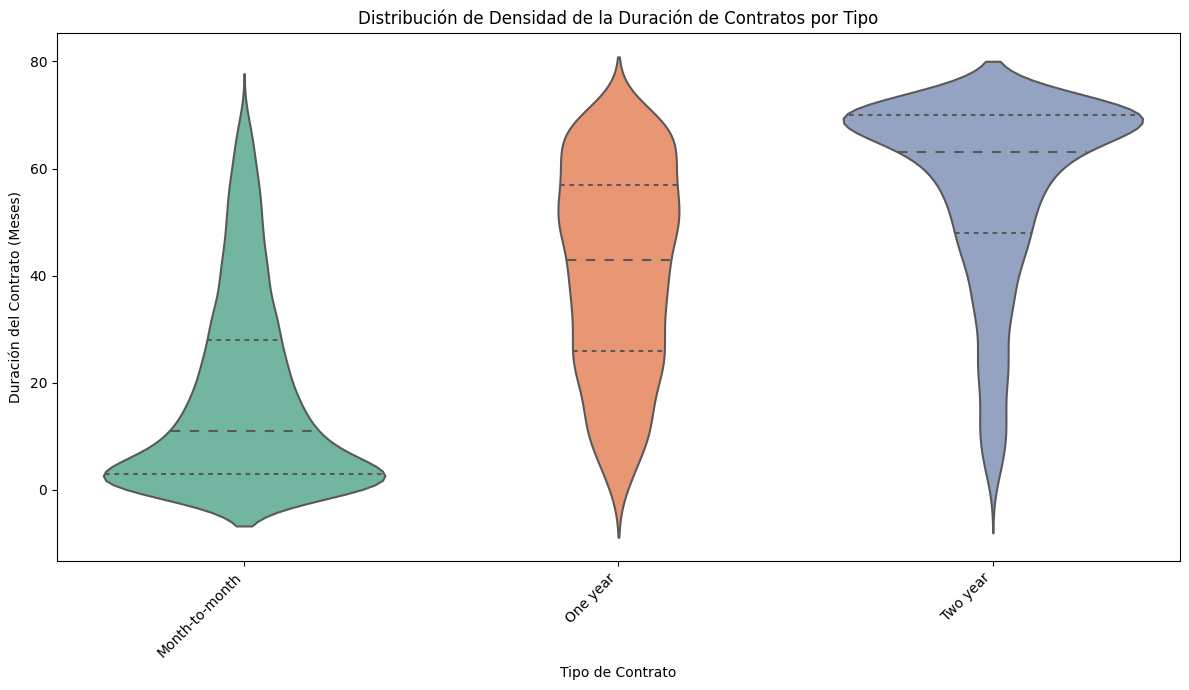

In [49]:
# Y su distribucion en un grfico de Violin en relacion con el tipo de contrato.
plt.figure(figsize=(12, 7))

# El Violin Plot combina un box plot con una estimación de densidad 
sns.violinplot(
    data=data, 
    x='type', 
    y='duration_months', 
    inner='quartile', 
    palette='Set2'
)

plt.title('Distribución de Densidad de la Duración de Contratos por Tipo')
plt.xlabel('Tipo de Contrato')
plt.ylabel('Duración del Contrato (Meses)')
plt.xticks(rotation=45, ha='right') 

plt.tight_layout()
plt.show()

Hemos terminado nuestro análisis de nuestros datos encontrado algunos datos que fue necesario rellenar, limpiar y procesar con el fin de mejorar nuestros datos para poderlo entrenar con los diferentes modelos.
Se encontraron datos relevantes que las personas que mas cancelan canto con un contrato de mes con mes los que no condiciona su servicio por lo que les da más libertad de cancelar sin preocuparse por la penalización o contratos que condicione el servicio.
La forma de pago con más cancelaciones en con cheque electrónico ara considerarlo más adelante.
El genero es un valor con una distribución muy similar por lo que no un dato tan relevante. 


## Entrenamiento

In [50]:
#Es momento de preparar los datos, revisamos.
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7032 non-null   object 
 1   type              7032 non-null   object 
 2   paperlessbilling  7032 non-null   int64  
 3   paymentmethod     7032 non-null   object 
 4   monthlycharges    7032 non-null   float64
 5   totalcharges      7032 non-null   float64
 6   internetservice   7032 non-null   object 
 7   onlinesecurity    7032 non-null   int64  
 8   onlinebackup      7032 non-null   int64  
 9   deviceprotection  7032 non-null   int64  
 10  techsupport       7032 non-null   int64  
 11  streamingtv       7032 non-null   int64  
 12  streamingmovies   7032 non-null   int64  
 13  gender            7032 non-null   object 
 14  seniorcitizen     7032 non-null   int64  
 15  partner           7032 non-null   int64  
 16  dependents        7032 non-null   int64  


In [51]:
#Nuestra columna objetivo
data['aim']

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: aim, Length: 7032, dtype: int64

In [52]:
#Eliminamos las columnas no necesarias.
data = data.drop(columns=['customerid', 'gender', 'aim_label'])


In [53]:
#Y comenzamos a balacer las clases. 
one_class = data[data['aim'] == 1]
zero_class = data[data['aim'] == 0]

# Contamos la diferencia de cantidades entre una clase y otra
difference = zero_class['aim'].count() - one_class['aim'].count()

# Aplicamos sobremuestreo con reemplazo de la clase 1 aumentando la mitad de la diferencia
new_ones = one_class.sample(difference//2, replace=True, random_state=12345)
new_ones

# Aplicamos submuestreo de la clase 0 reduciendo la mitad de la diferencia
new_zeros = zero_class.sample(len(zero_class)-(difference//2), replace=False, random_state=12345)

data = pd.concat([one_class, new_ones, new_zeros])
data = data.sample(frac=1, replace=False, random_state=12345).reset_index(drop=True)
data

,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,seniorcitizen,partner,dependents,multiplelines,aim,duration_days,duration_months
0,Month-to-month,0,Mailed check,19.25,19.25,None,0,0,0,0,0,0,0,0,1,0,1,31,1
1,Month-to-month,1,Electronic check,50.25,2203.65,DSL,0,0,0,0,0,0,0,1,0,1,1,1278,42
2,One year,0,Mailed check,20.10,533.90,None,0,0,0,0,0,0,0,1,0,0,0,699,23
3,Month-to-month,1,Electronic check,94.95,1760.25,Fiber optic,0,0,0,0,1,1,1,1,0,1,0,549,18
4,Month-to-month,1,Electronic check,81.05,2227.10,Fiber optic,0,0,0,0,0,1,0,1,1,0,1,852,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,Month-to-month,0,Electronic check,54.30,195.30,DSL,0,0,0,0,0,1,0,0,0,0,1,122,4
7028,Month-to-month,1,Mailed check,35.45,106.85,DSL,1,1,0,0,0,0,0,0,0,0,1,92,3
7029,Month-to-month,1,Electronic check,100.25,3527.60,Fiber optic,0,0,1,0,1,1,0,0,0,1,1,1065,35
7030,Two year,1,Electronic check,86.10,4890.50,DSL,1,1,1,0,1,1,0,1,0,1,0,1736,57


In [54]:
columns_to_standarize = ['monthlycharges', 'totalcharges','duration_days','duration_months']

# Instanciar y entrenar el estandarizador
scaler = StandardScaler()
scaler.fit(data[columns_to_standarize])

# Estandarizamos las columnas
data[columns_to_standarize] = scaler.transform(data[columns_to_standarize])
data.head()

,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,seniorcitizen,partner,dependents,multiplelines,aim,duration_days,duration_months
0,Month-to-month,0,Mailed check,-1.691476,-0.930692,None,0,0,0,0,0,0,0,0,1,0,1,-1.110191,-1.110600
1,Month-to-month,1,Electronic check,-0.615885,0.073123,DSL,0,0,0,0,0,0,0,1,0,1,1,0.616235,0.617060
2,One year,0,Mailed check,-1.661984,-0.694191,None,0,0,0,0,0,0,0,1,0,0,0,-0.185370,-0.183563
3,Month-to-month,1,Electronic check,0.935047,-0.130636,Fiber optic,0,0,0,0,1,1,1,1,0,1,0,-0.393039,-0.394253
4,Month-to-month,1,Electronic check,0.452766,0.083900,Fiber optic,0,0,0,0,0,1,0,1,1,0,1,0.026453,0.027127


In [55]:
# Columnas a transformar con codificación
columns_to_code = ['type', 'paymentmethod', 'internetservice']

# Creación de dataframe con caractirizticas Ordinales
data_ordinal = data.copy()

encoder = OrdinalEncoder()
data_ordinal[columns_to_code] = encoder.fit_transform(data_ordinal[columns_to_code])
data_ordinal.head()

,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,seniorcitizen,partner,dependents,multiplelines,aim,duration_days,duration_months
0,0.0,0,3.0,-1.691476,-0.930692,2.0,0,0,0,0,0,0,0,0,1,0,1,-1.110191,-1.110600
1,0.0,1,2.0,-0.615885,0.073123,0.0,0,0,0,0,0,0,0,1,0,1,1,0.616235,0.617060
2,1.0,0,3.0,-1.661984,-0.694191,2.0,0,0,0,0,0,0,0,1,0,0,0,-0.185370,-0.183563
3,0.0,1,2.0,0.935047,-0.130636,1.0,0,0,0,0,1,1,1,1,0,1,0,-0.393039,-0.394253
4,0.0,1,2.0,0.452766,0.083900,1.0,0,0,0,0,0,1,0,1,1,0,1,0.026453,0.027127


In [56]:
data_ohe = data.copy()

# Codificación OHE
OHE = pd.get_dummies(data_ohe[columns_to_code], drop_first=True)

# Inserción de las columnas codificadas
data_ohe.drop(labels=columns_to_code, inplace=True, axis=1)
data_ohe = pd.concat([data_ohe, OHE], axis=1)
data_ohe.head()

,paperlessbilling,monthlycharges,totalcharges,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,seniorcitizen,...,aim,duration_days,duration_months,type_One year,type_Two year,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,internetservice_Fiber optic,internetservice_None
0,0,-1.691476,-0.930692,0,0,0,0,0,0,0,...,1,-1.110191,-1.110600,0,0,0,0,1,0,1
1,1,-0.615885,0.073123,0,0,0,0,0,0,0,...,1,0.616235,0.617060,0,0,0,1,0,0,0
2,0,-1.661984,-0.694191,0,0,0,0,0,0,0,...,0,-0.185370,-0.183563,1,0,0,0,1,0,1
3,1,0.935047,-0.130636,0,0,0,0,1,1,1,...,0,-0.393039,-0.394253,0,0,0,1,0,1,0
4,1,0.452766,0.083900,0,0,0,0,0,1,0,...,1,0.026453,0.027127,0,0,0,1,0,1,0


In [57]:
# Seleccionamos las características
features = data_ordinal.drop(labels=['aim'], axis=1)
ohe_features = data_ohe.drop(labels=['aim'], axis=1)

target = data['aim']

In [58]:
#Separamos los conjuntos
features_train, features_test, features_train_ohe, features_test_ohe, target_train, target_test = train_test_split(
    features,
    ohe_features,                  # Características codificadas
    target,                        # Variable objetivo
    test_size=0.25,
    random_state=12345,
    stratify=target              
)

In [59]:
#Revisamos nuestro cojuntos
print("--- Tamaños de los Conjuntos OHE ---")
print(f"Características de Entrenamiento OHE: {features_train_ohe.shape}")
print(f"Características de Prueba OHE:      {features_test_ohe.shape}")
print(f"Objetivo de Entrenamiento:          {target_train.shape}")
print(f"Objetivo de Prueba:                 {target_test.shape}")

--- Tamaños de los Conjuntos OHE ---
Características de Entrenamiento OHE: (5274, 22)
Características de Prueba OHE:      (1758, 22)
Objetivo de Entrenamiento:          (5274,)
Objetivo de Prueba:                 (1758,)


In [60]:
features_train_ohe

,paperlessbilling,monthlycharges,totalcharges,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,seniorcitizen,...,multiplelines,duration_days,duration_months,type_One year,type_Two year,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,internetservice_Fiber optic,internetservice_None
1106,0,-0.216876,0.450175,1,0,1,1,0,0,0,...,0,0.869591,0.869888,0,0,0,0,0,0,0
3919,1,-1.481562,-0.171029,0,0,0,0,0,0,0,...,1,1.586743,1.586235,0,1,1,0,0,0,1
5377,1,0.058961,-0.793911,0,0,0,0,0,0,0,...,0,-0.941287,-0.942048,0,0,0,1,0,1,0
552,1,0.043348,-0.225416,0,0,0,0,0,0,0,...,0,-0.224135,-0.225701,0,0,0,1,0,1,0
3152,0,0.560325,0.248805,0,1,0,0,0,1,0,...,0,0.196742,0.195679,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6350,0,-1.653310,-0.870332,0,0,0,0,0,0,0,...,0,-0.898368,-0.899910,0,0,0,0,1,0,1
4289,1,-1.693210,-0.582822,0,0,0,0,0,0,0,...,0,0.617619,0.617060,1,0,0,0,1,0,1
2956,1,0.355616,-0.254390,0,1,1,0,0,0,0,...,0,-0.351505,-0.352115,0,0,0,1,0,1,0
4145,0,-1.370533,-0.650328,1,0,0,0,0,0,0,...,0,-0.308587,-0.309977,0,0,0,1,0,0,0


In [61]:
# Definimos la función para evaluar nuestros modelos.
def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    # 1. CALCULAR CROSS-VALIDATION ROC AUC 
    # Este cálculo permanece igual, ya que es independiente del loop.
    cv_scores = cross_val_score(
        estimator=model,
        X=train_features,
        y=train_target,
        cv=5,
        scoring='roc_auc'
    )
    cv_roc_auc = np.mean(cv_scores)

    # IMPRIMIR EL VALOR DE CV SEPARADAMENTE
    print(f"CV ROC AUC (5-Fold): {cv_roc_auc:.4f}\n")


    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}
            
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1 (Código de graficación sin cambios)
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1')

        # ROC (Código de graficación sin cambios)
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Curva ROC')

        # PRC (Código de graficación sin cambios)
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    
    # Reordenamos el índice sin incluir la métrica de CV
    reordered_index = ('Accuracy', 'F1', 'APS', 'ROC AUC')
    df_eval_stats = df_eval_stats.reindex(index=reordered_index)
    
    return df_eval_stats

### Modelo de Regresión Logística

In [62]:
model_lr = LogisticRegression(random_state=123 ,solver='liblinear', class_weight='balanced')
model_lr.fit(features_train_ohe, target_train)

LogisticRegression(class_weight='balanced', random_state=123,
                   solver='liblinear')

CV ROC AUC (5-Fold): 0.8389



,train,test
Accuracy,0.76,0.76
F1,0.77,0.77
APS,0.82,0.83
ROC AUC,0.84,0.85


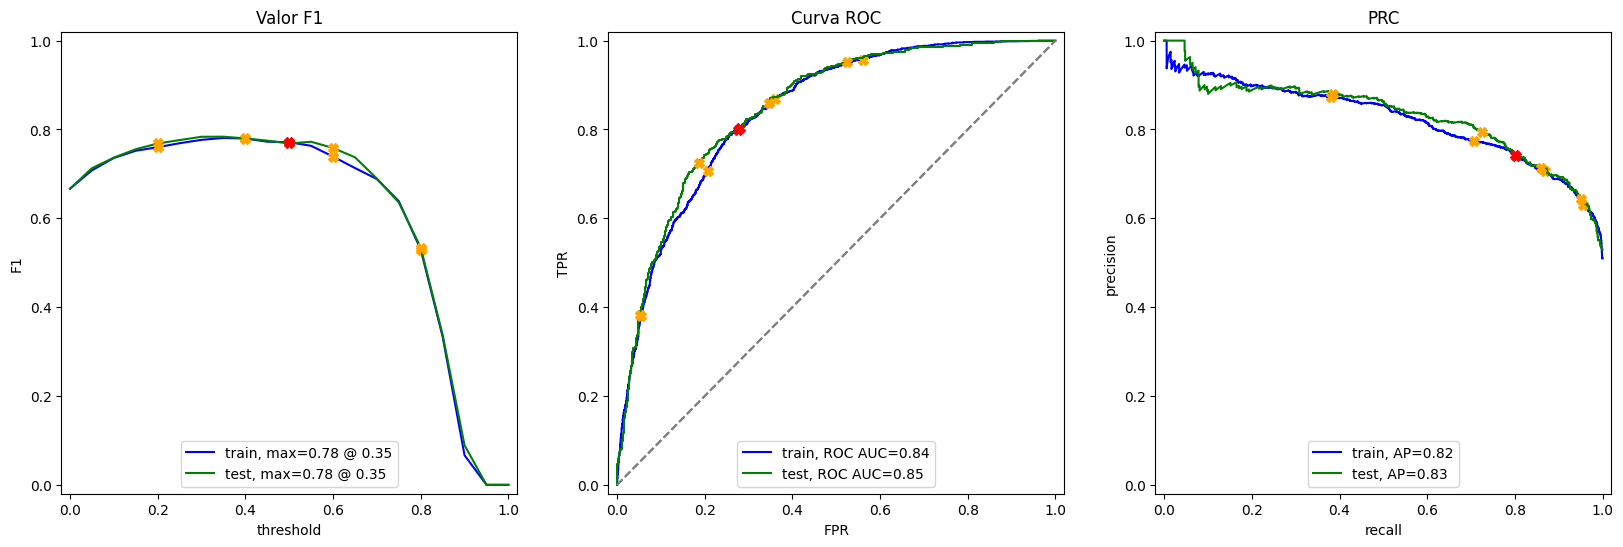

In [63]:
evaluate_model(model_lr, features_train_ohe, target_train, features_test_ohe, target_test)

## Clase SGDClassifier

In [64]:
model_sgd = SGDClassifier (loss='log', random_state=12345, max_iter=1000,
    class_weight='balanced')
model_sgd_fitted =  model_sgd.fit(features_train_ohe, target_train)

model_sgd_cal = CalibratedClassifierCV(model_sgd_fitted)
model_sgd_cal.fit(features_train_ohe, target_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(class_weight='balanced',
                                                    loss='log',
                                                    random_state=12345))

CV ROC AUC (5-Fold): 0.8389



,train,test
Accuracy,0.76,0.77
F1,0.77,0.78
APS,0.82,0.83
ROC AUC,0.84,0.85


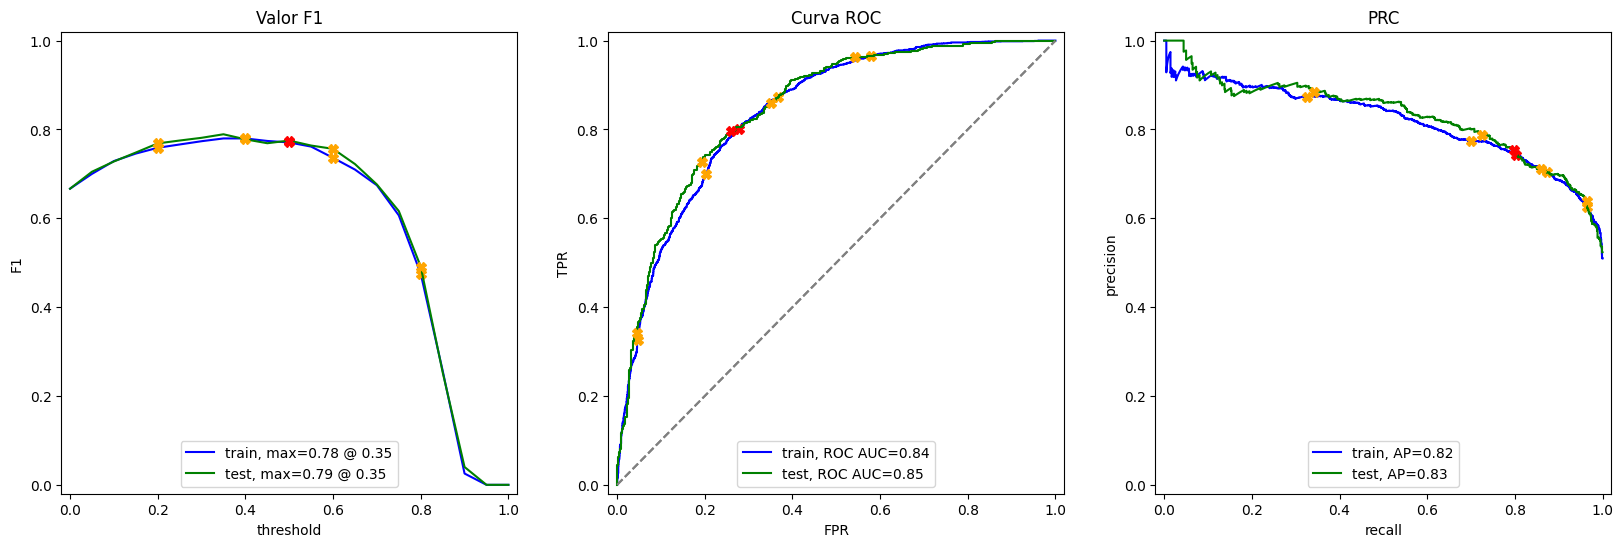

In [65]:
evaluate_model(model_sgd_cal, features_train_ohe, target_train, features_test_ohe, target_test)

## Decision Tree

In [66]:
param_grid_dt = {
    'max_depth': [3, 4, 5, 6, 7, 8],  
    
    'min_samples_leaf': [10, 20, 30, 40, 50],
    
    'criterion': ['gini', 'entropy'] 
}
     

In [67]:
model_dt = DecisionTreeClassifier (random_state=12345)

# 3. Configurar Grid Search
grid_search_dt = GridSearchCV(
    estimator=model_dt, 
    param_grid=param_grid_dt, 
    scoring='roc_auc',      # Usamos ROC AUC por ser robusta en clases desbalanceadas
    cv=5,                   # Usamos 5-Fold Cross-Validation
    verbose=1,              # Muestra progreso
    n_jobs=-1               # Usa todos los núcleos de tu CPU para acelerar
)

# 4. Entrenar (Ejecutar la búsqueda de la mejor combinación)
grid_search_dt.fit(features_train_ohe, target_train)

# 5. Imprimir los resultados
print("-------------------------------------------------")
print("Mejores Parámetros Encontrados:")
print(grid_search_dt.best_params_)

print(f"\nMejor ROC AUC promedio (Cross-Validation): {grid_search_dt.best_score_:.4f}")

# 6. Obtener el mejor modelo entrenado
best_model_dt = grid_search_dt.best_estimator_

Fitting 5 folds for each of 60 candidates, totalling 300 fits
-------------------------------------------------
Mejores Parámetros Encontrados:
{'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 10}

Mejor ROC AUC promedio (Cross-Validation): 0.8695


In [68]:
model_dt = DecisionTreeClassifier(max_depth=8, random_state=12345)
model_dt.fit(features_train_ohe, target_train)

DecisionTreeClassifier(max_depth=8, random_state=12345)

CV ROC AUC (5-Fold): 0.8626



,train,test
Accuracy,0.83,0.81
F1,0.84,0.82
APS,0.89,0.85
ROC AUC,0.91,0.88


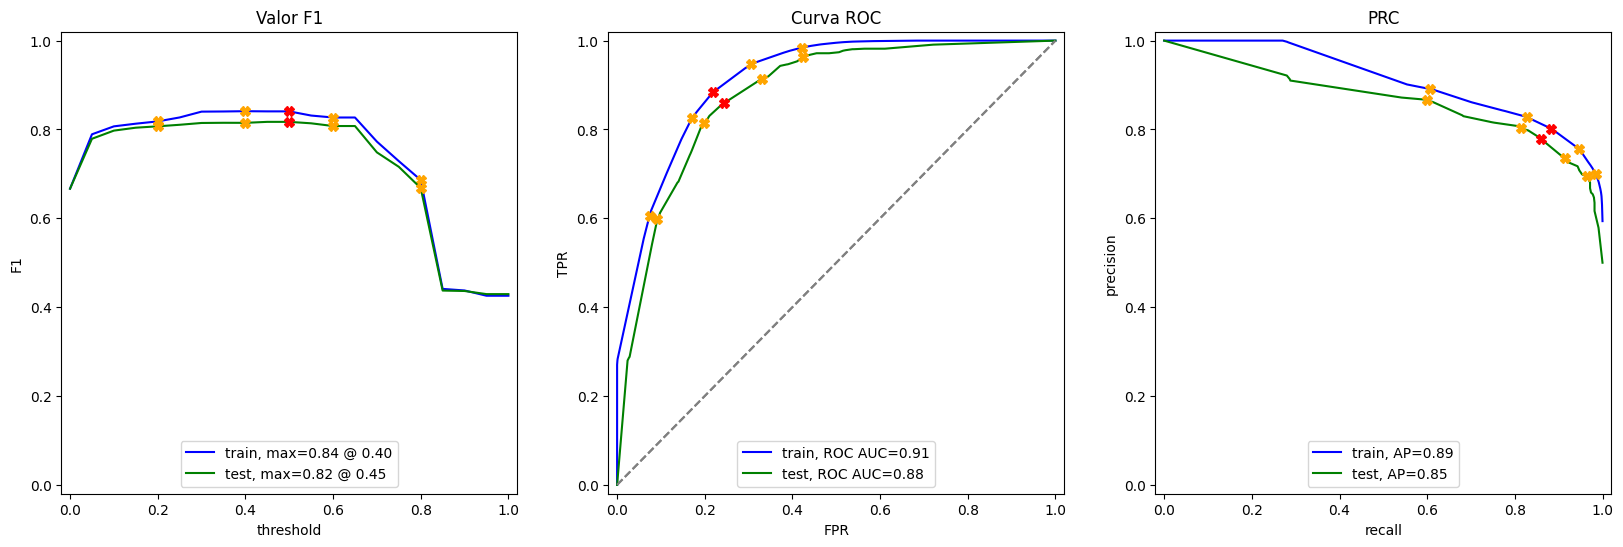

In [69]:
evaluate_model(model_dt, features_train_ohe, target_train, features_test_ohe, target_test)

## Random Forest 

In [70]:
def grid_search_random_forest(features_train, target_train):
    
    param_grid_rfc = {
    'max_depth': [7, 10, 15, 20],     
    'min_samples_leaf': [5, 10, 20, 30], 
    'n_estimators': [100, 200], 
    'max_features': ['sqrt'] 
}

    model_rfc = RandomForestClassifier(random_state=12345, class_weight='balanced')

    # Configurar Grid Search
    grid_search_rfc = GridSearchCV(
        estimator=model_rfc, 
        param_grid=param_grid_rfc, 
        scoring='roc_auc',      
        cv=5,                   # 5-Fold Cross-Validation
        verbose=1,              # Muestra progreso
        n_jobs=-1               # Usa todos los núcleos de la CPU
    )

    # Entrenar y Ejecutar la Búsqueda
    print("Iniciando Grid Search...")
    grid_search_rfc.fit(features_train, target_train)
    print("Grid Search completado.")

    # Extraer y Devolver Resultados
    best_model_rfc = grid_search_rfc.best_estimator_
    best_params = grid_search_rfc.best_params_
    best_score = grid_search_rfc.best_score_
    
    print("\n--- Resultados de la Búsqueda ---")
    print(f"Mejores Parámetros: {best_params}")
    print(f"Mejor ROC AUC promedio (CV): {best_score:.4f}")

    return best_model_rfc, best_params, best_score

In [71]:
best_rfc, rfc_params, rfc_score = grid_search_random_forest(features_train_ohe, target_train)
print("\nModelo optimizado listo para evaluación de prueba.")

Iniciando Grid Search...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Grid Search completado.

--- Resultados de la Búsqueda ---
Mejores Parámetros: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 200}
Mejor ROC AUC promedio (CV): 0.9023

Modelo optimizado listo para evaluación de prueba.


In [72]:
model_rfc = RandomForestClassifier(max_depth=5, max_features='sqrt', n_estimators=200, random_state=12345)
model_rfc.fit(features_train_ohe, target_train)

RandomForestClassifier(max_depth=5, max_features='sqrt', n_estimators=200,
                       random_state=12345)

CV ROC AUC (5-Fold): 0.8666



,train,test
Accuracy,0.79,0.79
F1,0.80,0.80
APS,0.86,0.86
ROC AUC,0.88,0.87


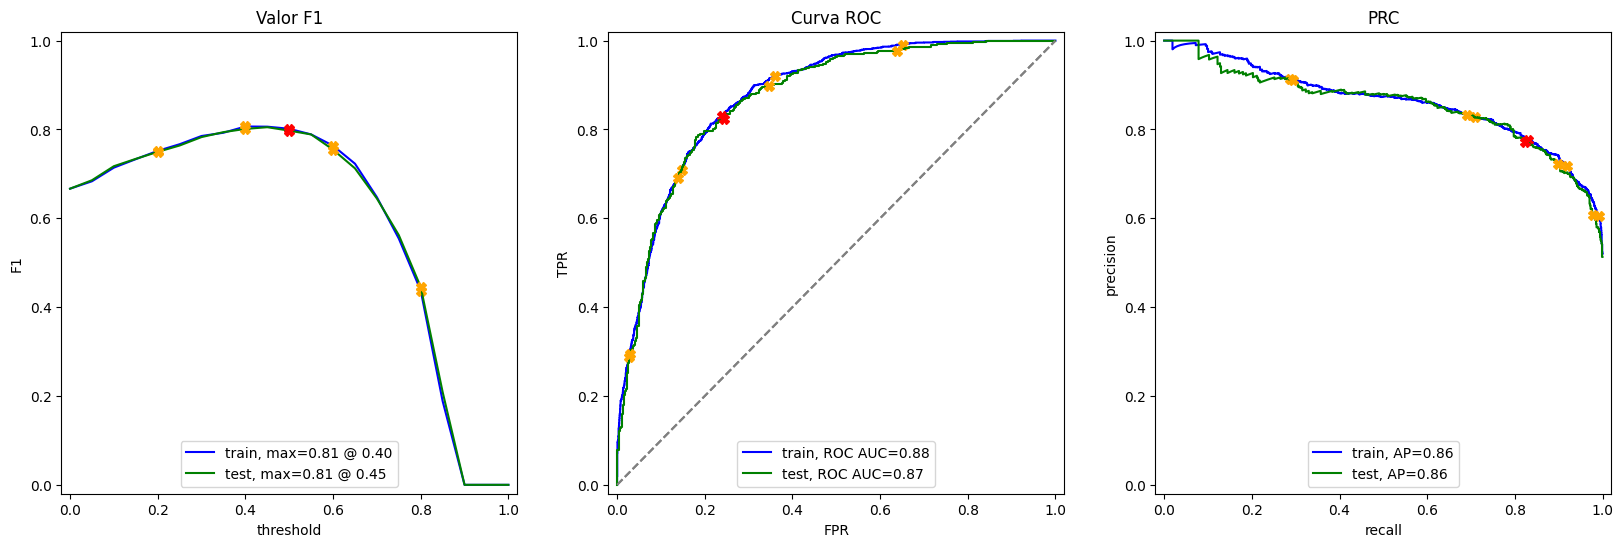

In [73]:
evaluate_model(model_rfc, features_train_ohe, target_train, features_test_ohe, target_test)

## CatBoostClassifier

In [74]:
features_train_clean = features_train_ohe.astype(int)
features_test_clean = features_test_ohe.astype(int)

In [75]:
X_train = features_train_ohe 
y_train = target_train

model_cat = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC', 
    random_state=12345,
    verbose=0, 
    auto_class_weights='Balanced', 
)

print("Iniciando entrenamiento de CatBoost...")
model_cat.fit(X_train, y_train) 
print("Entrenamiento de CatBoost completado.")

Iniciando entrenamiento de CatBoost...
Entrenamiento de CatBoost completado.


CV ROC AUC (5-Fold): 0.9219



,train,test
Accuracy,0.91,0.85
F1,0.91,0.85
APS,0.98,0.94
ROC AUC,0.97,0.93


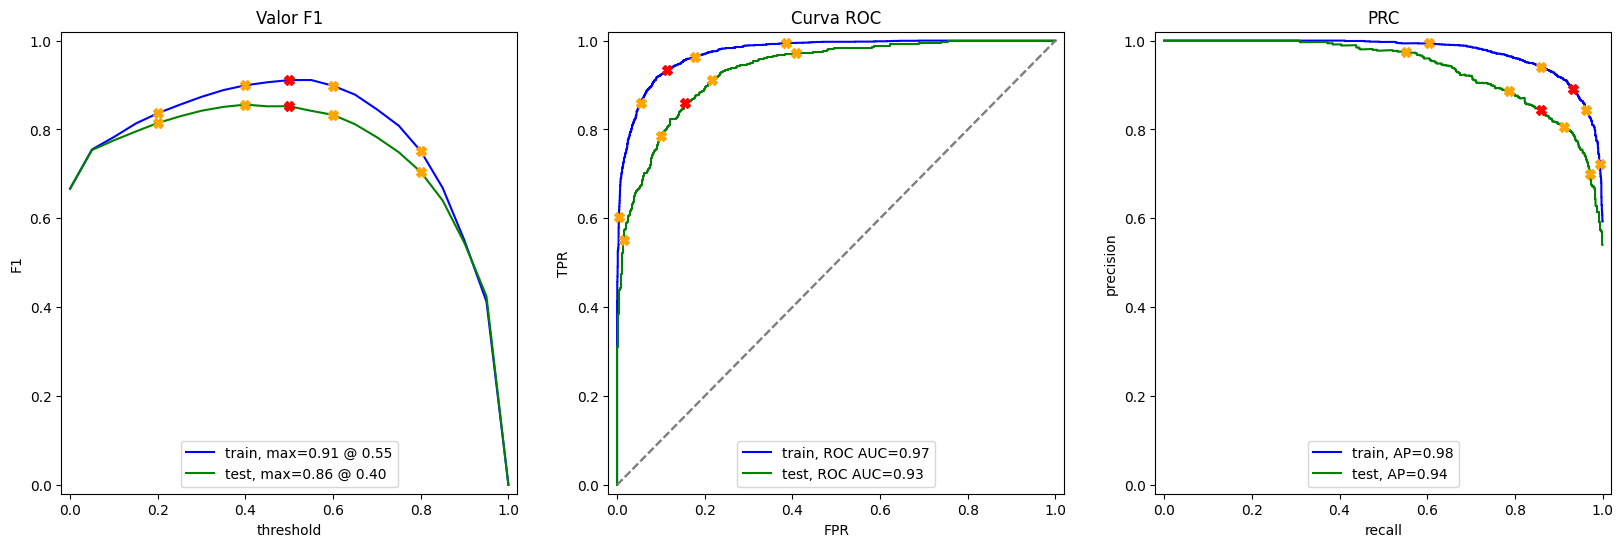

In [76]:
pred_proba_cat = model_cat.predict_proba(features_test_ohe)[:, 1]

evaluate_model(
    model=model_cat,
    train_features=features_train_ohe,
    train_target=target_train,
    test_features=features_test_ohe,
    test_target=target_test
)

## Conclusión

### Basándonos en el análisis exploratorio de datos (EDA) que hemos realizado hasta ahora, podemos extraer varias conclusiones importantes:

### Datos y Limpieza: 
Se cargaron y unificaron los datos de diferentes dataframe (contract, personal, internet, phone). Se identificaron y manejaron valores ausentes, particularmente en las columnas TotalCharges (eliminando 11 filas ya que no se consideraba que afectaran el analis) y las columnas de servicios de internet y telefonía (rellenando con 'None' o 0 para su mejor analisis). La columna TotalCharges se convirtió correctamente a tipo numérico.

### Distribución del Objetivo:
Existe un desbalance significativo en la variable objetivo (aim), donde la mayoría de los clientes no cancelan (aproximadamente 73.4%) y una minoría sí cancela (aproximadamente 26.6%). Esto justifica el uso de métricas como ROC AUC y APS para evaluar modelos, en lugar de depender únicamente de la exactitud.

### Análisis de Características Categóricas y Booleanas:
#### Tipo de Contrato: 
Los contratos mes a mes están fuertemente asociados con una mayor tasa de cancelación.
#### Método de Pago:
El cheque electrónico es el método de pago más común entre los clientes que cancelan.
 
#### Servicios Adicionales: 
La ausencia de servicios como seguridad en línea, copia de seguridad, protección de dispositivos y soporte técnico se correlaciona con una mayor propensión a cancelar.

#### Perfil del Cliente: 
Los ciudadanos mayores que no son pather y o que no tiene dependicia tienden a tener tasas de cancelación más altas.

#### Género y Líneas Múltiples: 
El género no parece ser un factor diferenciador importante en la cancelación. Pero los clientes con líneas múltiples tienen una tasa de cancelación ligeramente mayor.


### Análisis de Características Numéricas
Hay una correlación positiva moderada entre MonthlyCharges y TotalCharges, lo cual es esperado.

MonthlyCharges tiene una pequeña correlación positiva con la cancelación, sugiriendo que los clientes con cargos mensuales más altos podrían ser un poco más propensos a cancelar.

TotalCharges tiene una pequeña correlación negativa con la cancelación, lo que indica que los clientes que han estado más tiempo y han acumulado cargos totales más altos son menos propensos a cancelar.

### En conjunto, el EDA ha revelado que la duración del contrato, el tipo de contrato, el método de pago, la presencia de servicios adicionales y el perfil demográfico del cliente (ciudadano mayor, parther, dependencia) son factores clave relacionados con la cancelación. 
### Estos hallazgos son cruciales para la ingeniería de características y la selección de modelos en las etapas posteriores. A continiación mostramos los resultados del entrenamiento y evaluación de muestros modelos.

In [ ]:
#Analisamos los resultados.
resultados_acumulados = {}

print("--- Evaluando Regresión Logística ---")
df_lr = evaluate_model(
    model_lr, 
    features_train_ohe, 
    target_train, 
    features_test_ohe, 
    target_test
)
df_lr.loc[:, 'Model'] = 'Logistic Regression'
resultados_acumulados['Logistic Regression'] = df_lr

print("\n--- Evaluando SGDClassifier ---")
df_sgd = evaluate_model(
    model_sgd, 
    features_train_ohe, 
    target_train, 
    features_test_ohe, 
    target_test
)
df_sgd.loc[:, 'Model'] = 'SGDClassifier'
resultados_acumulados['SGDClassifier'] = df_sgd

print("\n--- Evaluando  Decision Tree ---")
df_dt = evaluate_model(
    model_dt, 
    features_train_ohe, 
    target_train, 
    features_test_ohe, 
    target_test
)
df_dt.loc[:, 'Model'] = 'Decision Tree'
resultados_acumulados['Decision Tree'] = df_dt


print("\n--- Evaluando Random Forest ---")
df_rfc = evaluate_model(
    model_rfc, 
    features_train_ohe, 
    target_train, 
    features_test_ohe, 
    target_test
)
df_rfc.loc[:, 'Model'] = 'Random Forest'
resultados_acumulados['Random Forest'] = df_rfc


print("\n--- Evaluando CatBoost ---")
df_cat = evaluate_model(
    model_cat, 
    features_train_ohe, 
    target_train, 
    features_test_ohe, 
    target_test
)
df_cat.loc[:, 'Model'] = 'CatBoost'
resultados_acumulados['CatBoost'] = df_cat



df_resultados_final = pd.concat(resultados_acumulados.values())

# Opcional: Reordenar las columnas para mostrar el nombre del modelo primero
column_order = ['Model', 'train', 'test']
df_resultados_final = df_resultados_final[column_order]

print("\n====================================")
print("     TABLA DE RESULTADOS FINALES    ")
print("====================================")
print(df_resultados_final)

--- Evaluando Regresión Logística ---
CV ROC AUC (5-Fold): 0.8389


--- Evaluando SGDClassifier ---
CV ROC AUC (5-Fold): 0.8351


--- Evaluando  Decision Tree ---
CV ROC AUC (5-Fold): 0.8626


--- Evaluando Random Forest ---


## CatBoostClassifier con un 0.93 de ROC AUC es el mejor modelo. Su ROC AUC de 0.93 y su APS de 0.94 en el conjunto de prueba son significativamente superiores a todos los demás modelos, lo que indica el mayor poder de discriminación y fiabilidad para predecir la fuga de clientes.


### Analisamos la importacncia de cada caracteristica.

In [ ]:
#El modelo CatBoost ya ha calculado la importancia de cada característica durante el entrenamiento.
# Por lo que vamos a extraer la importancia de las características
feature_importance = model_cat.get_feature_importance()
feature_names = features_train_ohe.columns

# Crear un DataFrame para un manejo y visualización sencillos
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Visualizar las 15 características más importantes
plt.figure(figsize=(10, 8))

# Usamos un gráfico de barras horizontal para facilitar la lectura
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=importance_df.head(15), 
    palette='viridis' # Una paleta de colores atractiva
)

plt.title('Top 15 Características Más Importantes (CatBoost)', fontsize=16)
plt.xlabel('Importancia Relativa', fontsize=12)
plt.ylabel('Característica', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Imprimir las 10 principales en formato de tabla
print("--- Top 10 Características que Predicen la Fuga ---")
print(importance_df.head(10).round(2))

### El gráfico y la tabla nos muestra qué variables tienen el mayor impacto en la predicción del modelo. Resaltando la antiguedad como el factor más importante y el tipo de contrato que como ya habiamos visto anterirormente al ser corto en el caso mes con mes tiene un riesgo de fuga mucho mayor. Y otros valores para el analisis como el tipo de tecnologia o servicio de internet que estan ligados a la decisión de cancelar.

### Los hallazgos de este análisis proporcionan información valiosa para el equipo de marketing. Las estrategias de retención deben enfocarse en:

Clientes con contratos mes a mes.

Clientes que utilizan cheque electrónico como método de pago.

Clientes que no tienen servicios adicionales; se podría incentivar la contratación de estos servicios.

Clientes que son personas mayores o que no son parther, ni tenen una dependencia, ofreciéndoles planes o promociones específicas.

Clientes nuevos o con poca antigüedad, ya que el riesgo de cancelación es mayor en las primeras etapas del contrato pr o que deberian incremenar los beneficios en los contraros de mayor tiempo.

## En conclusión, hemos desarrollado un modelo predictivo robusto utilizando CatBoost que puede ayudar a identificar a los clientes con mayor riesgo de cancelación. La información sobre las características más importantes proporciona una base sólida para que el equipo de marketing diseñe e implemente estrategias de retención dirigidas y efectivas en estos sectores.